# KICKSTARTER PROJECT

sample urls of different types of page structures-

### Project page: 
Ended campaign- <br>
url = 'https://www.kickstarter.com/projects/legendarycomics/trick-r-treat-witching-hour'

Live campaign- <br>
url = 'https://www.kickstarter.com/projects/cheekydogtoys/cheeky-the-strongest-and-safest-dog-toy'

### Profile page: 
url = 'https://www.kickstarter.com/profile/emibrady/'

### Hidden page:
url = 'https://www.kickstarter.com/projects/1588486640/turtle-island-to-abya-yala-a-new-anthology-by-nati'

# import libraries

In [2]:
import pandas as pd
from datetime import datetime
import re
import csv
import matplotlib.pyplot as plt


import selenium
from seleniumbase import Driver
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup





In [2]:
df = pd.read_csv('kickstarter_url.csv')

In [3]:
df.head(10)

,legacy_id,url
0,1,http://www.kickstarter.com/projects/1569090293...
1,2,http://www.kickstarter.com/projects/1862402066...
2,3,http://www.kickstarter.com/projects/460275866/...
3,4,http://www.kickstarter.com/projects/1588486640...
4,5,http://www.kickstarter.com/projects/darian/abyss
5,6,http://www.kickstarter.com/projects/poeina/poe...
6,7,http://www.kickstarter.com/projects/524168246/...
7,8,http://www.kickstarter.com/projects/amandakirk...
8,9,http://www.kickstarter.com/projects/469077793/...
9,10,http://www.kickstarter.com/projects/wakingbeau...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80134 entries, 0 to 80133
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   legacy_id  80134 non-null  int64 
 1   url        80134 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [5]:
# # code testing
# browser = Driver(uc=True, headless = True)
# # url = 'https://www.kickstarter.com/projects/legendarycomics/trick-r-treat-witching-hour'
# # url = 'https://www.kickstarter.com/profile/emibrady/'
# # url = "https://www.kickstarter.com/projects/kisso/novel-sabae-ear-pick-optimumly-angled-for-relief-and-cleaning"
# # url = "http://www.kickstarter.com/projects/513109318/new-studio-project-really-southern-cross"
# # url = "https://www.kickstarter.com/profile/513109318"
# url = "http://www.kickstarter.com/projects/1806920364/delightful-childrens-book-deja-wheres-my-shoe"
# browser.uc_open_with_reconnect(url, 4)
# soup = BeautifulSoup(browser.page_source, 'html.parser')


# Get all data from project page

In [6]:
# get campaign urls on profile pg
def get_campaigns_data(campaign_urls, browser):
    more_pages = True
    
    while more_pages:
        project_cards = browser.find_elements(By.CSS_SELECTOR, "ol.project-card-list > div > div.grid-row > div")

        for card in project_cards:
            campaign_url = card.find_element(By.CSS_SELECTOR, "a.project-card__title").get_attribute("href")
            campaign_urls.append(campaign_url)        
        next_button = browser.find_elements(By.CSS_SELECTOR, "a.next_page")
        if next_button:
            next_button[0].click()
            browser.sleep(2)
        else:
            more_pages = False 
    return campaign_urls

In [7]:
# main func to get data on projects page and profile page
def get_kickstarter_campaign_data(url):
    browser = Driver(uc=True, headless = True)

    try:
        campaign_data = {}

        browser.uc_open_with_reconnect(url, 4)

        
        WebDriverWait(browser, 20).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))
        )

        soup = BeautifulSoup(browser.page_source, 'html.parser')


        # check to stop the script when a hidden project page is found like - https://www.kickstarter.com/projects/1588486640/turtle-island-to-abya-yala-a-new-anthology-by-nati
        try:
            hidden_project_element = WebDriverWait(browser, 3).until(
                EC.presence_of_element_located((By.ID, "hidden_project"))
            )
            fieldnames = [
                "Update", "Campaign Highlight", "Staff Pick", "Video",
                "Creator Name", "Creator Profile URL", "Category", "Created At", "Ended At", 
                "FAQ", "Campaign Name", "Funds Raised", "Backers", "Location",
                "US Campaign", "Funding Goal", "Campaign Description",
                "First Created", "Creator Joined At", "Creator Backed Campaigns Count", 
                "Creator Created Campaigns Count", "Creator backed campaigns", "Creator created campaigns"
            ]
            for field in fieldnames:
                campaign_data[field] = None    
            return campaign_data
        except Exception:
            print("Not a hidden page.")
     

        # campaign has ended check
        creator_name_element = soup.find("div", class_="creator-name")
        if creator_name_element:
            name_element = creator_name_element.find("span")
            creator_name = name_element.get_text(strip=True) if name_element else None
        else:
            creator_name = None
        
        # Check if "Funding period" exists
        funding_period = any("Funding period" in h3.text for h3 in browser.find_elements(By.TAG_NAME, "h3"))

        h3_elements = WebDriverWait(browser, 10).until(
            EC.presence_of_all_elements_located((By.TAG_NAME, "h3"))
        )        
        funding_period = any("Funding period" in h3.text for h3 in h3_elements)
        funding_period_exists = True if creator_name and funding_period else False

        # 1.1) Update: How often the campaign has been updated
        try:
            a_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, "project-nav__link--updates"))
            )           
            update_info = a_element.find_element(By.CLASS_NAME, "count").text
            campaign_data["Update"] = update_info
        except Exception as e:
            campaign_data["Update"] = None

        # 1.2) Campaign Highlight: Highlighted description of the campaign
        try:
            meta_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'meta[property="og:description"]'))
            )
            highlight = meta_element.get_attribute("content")
            campaign_data["Campaign Highlight"] = highlight
        except Exception as e:
            campaign_data["Campaign Highlight"] = None

        # 1.3) Staff Pick: Whether the campaign is highlighted with 'Project We Love'
        # if funding ended, the "proj we love"  will be under campaigns tab
        try:
            if funding_period_exists:                
                container_element = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='/discover/pwl']"))
                )    
                staff_pick = container_element.text
            else:
                container_element = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "auto-scroll-x"))
                )
                staff_pick = container_element.find_element(By.CLASS_NAME, "ml1").text
            campaign_data["Staff Pick"] = 1 if "Project We Love" in staff_pick else 0
        except Exception as e:
            campaign_data["Staff Pick"] = 0
            

        # 1.4) Video: Whether the campaign includes a product video
        # if funding ended, the "video" will be under campaigns tab
        try:
            video_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.TAG_NAME, "video"))
            )
            source_elements = video_element.find_elements(By.TAG_NAME, "source")
            base_mp4_sources = [
                source.get_attribute("src") 
                for source in source_elements 
                if "video/mp4" in source.get_attribute("type") and "_base.mp4" in source.get_attribute("src")
            ] 
            if len(base_mp4_sources) > 0:
                for url in base_mp4_sources:
                    campaign_data["Video"] = url
            else:
                campaign_data["Video"] = None

        except Exception as e:
            campaign_data["Video"] = None

        # 1.5) Creator Name: The creator's screen name
        try:
            if funding_period_exists:                
                creators_name = creator_name
            else:
                creator_bio_element = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.ID, "experimental-creator-bio"))
                )
                creators_name = creator_bio_element.find_element(By.CLASS_NAME, "text-ellipsis").text    
            campaign_data["Creator Name"] = creators_name
        except Exception as e:
            campaign_data["Creator Name"] = None

        # 1.6) Creator Profile URL: The creator profile link
        try:
            meta_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'meta[property="kickstarter:creator"]'))
            )   
            creator_url = meta_element.get_attribute("content")
            campaign_data["Creator Profile URL"] = creator_url
        except Exception as e:
            campaign_data["Creator Profile URL"] = None

        # 2.9) Product category: The category of the campaign.
        # if funding ended, the "category"  will be under campaigns tab
        try:
            if funding_period_exists:                
                category_container = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "NS_projects__category_location"))
                )
                category_link = category_container.find_element(By.CSS_SELECTOR, "a[href*='ref=category']")
                category_name = category_link.text
            else:
                category_link = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='ref=project_category_badge']"))
                )
                category_name = category_link.text                
            campaign_data["Category"] = category_name
        except Exception as e:
            campaign_data["Category"] = None


        # 2.10) Created at: The date when the campaign starts in YYYY-MM-DD format. (updates tab click)
        try:
            if funding_period:
                time_element = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, ".NS_campaigns__funding_period time:first-of-type"))
                )               
                date_text = time_element.text  # Dec 04 2024
                date_obj = datetime.strptime(date_text, "%b %d %Y")               
                formatted_date = date_obj.strftime("%Y-%m-%d") 
                campaign_data["Created At"] = formatted_date        
            else:
                updates_tab = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "project-nav__link--updates"))
                )                
                updates_tab.click()
                browser.sleep(2)  
                
                while True:
                    try:
                        load_more_buttons = WebDriverWait(browser, 10).until(
                            EC.visibility_of_all_elements_located((By.CLASS_NAME, "ksr-button"))
                        )
                        load_more_button = next(
                            (btn for btn in load_more_buttons if "Load more" in btn.text), None
                        )
                        if load_more_button:
                            load_more_button.click()  
                            browser.sleep(2)  
                        else:
                            break 
                    except Exception as e:
                        break
                try:
                    grid_containers = WebDriverWait(browser, 10).until(
                        EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div.bg-grey-100 div.grid-container'))
                    )
                    last_container = grid_containers[-1]  
                    second_last_container = grid_containers[-2] 
                    formatted_date = None
                    for container in [last_container, second_last_container]:
                        try:
                            date_text = container.find_element(By.CLASS_NAME, 'type-11.type-14-sm.text-uppercase').text
                            if date_text:
                                date_obj = datetime.strptime(date_text, "%B %d, %Y")                
                                formatted_date = date_obj.strftime("%Y-%m-%d")
                                break  
                        except:
                            continue  
                    
                    campaign_data["Created At"] = formatted_date  
                    campaigns_tab = WebDriverWait(browser, 10).until(
                        EC.presence_of_element_located((By.CLASS_NAME, "project-nav__link--campaign"))
                    )
                    campaigns_tab.click()
                    browser.sleep(2)
                except Exception as e:
                    campaign_data["Created At"] = None
        except Exception as e:
            campaign_data["Created At"] = None

        # 2.11) Ended at: The date when the campaign ends in YYYY-MM-DD format
        try:
            if funding_period:
                time_element = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, ".NS_campaigns__funding_period time:nth-of-type(2)"))
                )
                date_text = time_element.text    
                date_obj = datetime.strptime(date_text, "%b %d %Y")                
                formatted_date = date_obj.strftime("%Y-%m-%d")
            else:
                deadline_element = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "[data-test-id='deadline-exists']"))
                )
                data_test_id = deadline_element.get_attribute("data-test-id")                
                deadline_text = deadline_element.text                
                date_match = re.search(r'([A-Za-z]+ \d{1,2} \d{4})', deadline_text)
                if date_match:
                    date_value = date_match.group(1)             
                    date_object = datetime.strptime(date_value, "%B %d %Y")
                    formatted_date = date_object.strftime("%Y-%m-%d")
            campaign_data["Ended At"] = formatted_date        
        except Exception as e:
            campaign_data["Ended At"] = None

        # 2.12)	FAQ: The number of FAQs the campaign has posted.
        try:
            faq_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.ID, "faq-emoji"))
            )
            faq_text = faq_element.text
            faq_number = int(re.search(r'\d+', faq_text).group())
            campaign_data["FAQ"] = faq_number
        except Exception as e:
            campaign_data["FAQ"] = 0


        # 2.2) Campaign name
        try:
            meta_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'meta[property="og:title"]'))
            )
            campaign_data["Campaign Name"]  = meta_element.get_attribute("content")
        except Exception as e:
            campaign_data["Campaign Name"]  = None

        # 2.3) Funds raised: The total amount of funds raised for the campaign in USD.
        try:
            if funding_period_exists:                
                funds_raised = soup.find('span', class_='money').get_text().strip()
            else:
                funds_raised = soup.find('span', class_='soft-black').get_text().strip()
            campaign_data["Funds Raised"] = funds_raised
        except Exception as e:
             campaign_data["Funds Raised"] = None
        
        # 2.4) Backers: The total number of backers for the campaign.
        try:
            if funding_period_exists:   
                div_tag = soup.find('div', class_='mb0')
                number_of_backers = div_tag.find('h3', class_='mb0').text.strip()
            else:
                number_of_backers = soup.find('div', class_='block type-16 type-28-md bold dark-grey-500').span.text
            campaign_data["Backers"] = number_of_backers      
        except Exception as e:
             campaign_data["Backers"] = None

        # 2.5) Location: The location of the campaign.
        try:
            if funding_period_exists:                
                location_container = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, "NS_projects__category_location"))
                )
                location_link = location_container.find_element(By.CSS_SELECTOR, "a[href*='ref=city']")
                location_name = location_link.text
            else:
                location_link = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='ref=project_location_badge']"))
                )
                location_name = location_link.text                
            campaign_data["Location"] = location_name
        except Exception as e:
            campaign_data["Location"] = None


        #2.6) US campaign: 1 if the campaign is located in the US, 0 otherwise.
        try:
            us_states = [
            'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
            'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
            'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
            ]
            campaign_data["US Campaign"] = 1 if any(state in campaign_data['Location'] for state in us_states) else 0  
        except Exception as e:
            campaign_data["US Campaign"] = 0


        #2.7) Funding goal: The funding goal in USD.
        try:
            if funding_period_exists:                
                 funding_goal = soup.find('div', class_='type-12 medium navy-500').find('span', class_='money').text
            else:
                 funding_goal = soup.find('span', class_='money').text
            campaign_data["Funding Goal"] = funding_goal
        except Exception as e:
            campaign_data["Funding Goal"] = None

        # 2.8) Campaign description: Textual descriptions of the campaign in the Story area (all paragraphs).
        try:
            story_section = soup.find("div", {"class": "rte__content"})
            campaign_data["Campaign Description"] = " ".join([p.get_text(strip=True) for p in story_section.find_all("p")])
        except Exception as e:
            campaign_data["Campaign Description"] = None
            

        # click the profile to get further data on profile page
        try:
            if funding_period_exists:                
                # Click to open profile modal dialog
                link = WebDriverWait(browser, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, "a.hero__link.remote_modal_dialog"))
                )
                link.click() 

                # Click inside the profile modal dialog
                span = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "header a[href*='/profile/'] span"))
                )
                span.click()
                
            else:
                # open profile dialog
                creator_bio_div = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located((By.ID, "experimental-creator-bio"))
                )
                creator_bio_div.click()
                browser.sleep(2)  
                
                dialog_links = WebDriverWait(browser, 10).until(
                    EC.presence_of_all_elements_located((By.TAG_NAME, "a"))
                )
                for link in dialog_links:
                    href = link.get_attribute("href")
                    if "/profile/" in href:
                        browser.execute_script("arguments[0].removeAttribute('target');", link)
                        link.click()
                        break                       
        except Exception as e:
           print("Error clicking profile tab")


        # 1.7) First Created: Whether the campaign is the first by the creator
        try:
            created_section = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.ID, "profile_created"))
            )
            created_count = created_section.find_element(By.CLASS_NAME, "count").text.strip()
            is_first_campaign = int(created_count) == 1
            campaign_data["First Created"] = "Yes" if is_first_campaign else "No"
        except Exception as e:
            campaign_data["First Created"] = None  

        # 1.8) Creator Joined At: The date when the creator joined Kickstarter
        try:
            time_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, "js-adjust-time"))
            )
            creation_date_text = time_element.text
            campaign_data["Creator Joined At"] = creation_date_text
        except Exception as e:
            campaign_data["Creator Joined At"] = None

        # 1.9) Creator Backed Campaigns Count: The count of other campaigns the creator has backed
        try:
            a_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.ID, "profile_backed"))
            )
            backed_count = a_element.find_element(By.CLASS_NAME, "count").text
            campaign_data["Creator Backed Campaigns Count"] = backed_count
        except Exception as e:
            campaign_data["Creator Backed Campaigns Count"] = None
            

        # 1.11) Creator Created Campaigns Count: The count of campaigns the creator has created
        try:
            a_element = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.ID, "profile_created"))
            )
            created_count = a_element.find_element(By.CLASS_NAME, "count").text
            campaign_data["Creator Created Campaigns Count"] = created_count
        except Exception as e:
            campaign_data["Creator Created Campaigns Count"] = None

        
        # 1.10) Creator backed campaigns: The campaign URLs backed by the creator.
        try:
            # click backed tab
            backed_tab = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "a#profile_backed"))
            )
            backed_tab.click() 
            browser.sleep(.1)
            
            backed_campaign_urls = get_campaigns_data([], browser)
            campaign_data["Creator backed campaigns"] = backed_campaign_urls
        except Exception as e:
            campaign_data["Creator backed campaigns"] = None

        # 1.12) Creator created campaigns: The campaign URLs created by the creator.
        try:
            #click created tab
            created_tab = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "a#profile_created"))
            )
            created_tab.click() 
            browser.sleep(.1)
            
            created_campaign_urls = get_campaigns_data([], browser)
            campaign_data["Creator created campaigns"] = created_campaign_urls
        except Exception as e:
            campaign_data["Creator created campaigns"] = None
            
        return campaign_data
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return None
    finally:
        browser.quit()


In [10]:
def save_campaign_data_to_csv(df, csv_file):
    fieldnames = [
        "Legacy ID", "Campaign URL", "Update", "Campaign Highlight", "Staff Pick", "Video",
        "Creator Name", "Creator Profile URL", "Category", "Created At", "Ended At", 
        "FAQ", "Campaign Name", "Funds Raised", "Backers", "Location",
        "US Campaign", "Funding Goal", "Campaign Description",
        "First Created", "Creator Joined At", "Creator Backed Campaigns Count", 
        "Creator Created Campaigns Count", "Creator backed campaigns",  "Creator created campaigns"
    ]
    
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames = fieldnames)
        writer.writeheader()  

    # for index, row in df.head(3).iterrows():
    for index, row in df.iloc[1:26712].iterrows():
        print(f"current index: {index}")
        url = row['url']
        legacy_id = row['legacy_id']
        campaign_data = get_kickstarter_campaign_data(url)
        if campaign_data:
            campaign_data["Legacy ID"] = legacy_id
            # 2.1) campaign url
            campaign_data["Campaign URL"] = url
            with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames = fieldnames)
                writer.writerow(campaign_data)

In [11]:
save_campaign_data_to_csv(df, 'output_kickstarter_Data.csv')

current index: 4266


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
Error clicking profile tab
current index: 4267


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4268


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4269


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4270


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4271


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4272


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4273


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4274


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4275


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4276


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4277


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4278


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4279


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4280


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 4281


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4282


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4283


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4284


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4285


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4286


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4287


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4288


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4289


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4290


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4291


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4292


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4293


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4294


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4295


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4296


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4297


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4298


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4299


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4300


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4301


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4302


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4303


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4304


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4305


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4306


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4307


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4308


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4309


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4310


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4311


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4312


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4313


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4314


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4315


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4316


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4317


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4318


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4319


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4320


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4321


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4322


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4323


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4324


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4325


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4326


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4327


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4328


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4329


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4330


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4331


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4332


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4333


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4334


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4335


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4336


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4337


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4338


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4339


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4340


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4341


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4342


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4343


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4344


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4345


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4346


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4347


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4348


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4349


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4350


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4351


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4352


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4353


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4354


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4355


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4356


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4357


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4358


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4359


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4360


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4361


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4362


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4363


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4364


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4365


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4366


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4367


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4368


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4369


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4370


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4371


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4372


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4373


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4374


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4375


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4376


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4377


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4378


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4379


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4380


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4381


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4382


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4383


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4384


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4385


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4386


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4387


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4388


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4389


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4390


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4391


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4392


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4393


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4394


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4395


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4396


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4397


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4398


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4399


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4400


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4401


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4402


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4403


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4404


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4405


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4406


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4407


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4408


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4409


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4410


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4411


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4412


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4413


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4414


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4415


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4416


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4417


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4418


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4419


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4420


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4421


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4422


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4423


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4424


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4425


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4426


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4427


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4428


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4429


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4430


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4431


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4432


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4433


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4434


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4435


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4436


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4437


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4438


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4439


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4440


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4441


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4442


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4443


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4444


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4445


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4446


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4447


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4448


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4449


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4450


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4451


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4452


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4453


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4454


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4455


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4456


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4457


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4458


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4459


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4460


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4461


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4462


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4463


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4464


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4465


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4466


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4467


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4468


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4469


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4470


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4471


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4472


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4473


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4474


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4475


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4476


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4477


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4478


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4479


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4480


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4481


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4482


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4483


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4484


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4485


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4486


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4487


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4488


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4489


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4490


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4491


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4492


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4493


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4494


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4495


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4496


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4497


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4498


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4499


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4500


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4501


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4502


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4503


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4504


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4505


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4506


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4507


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4508


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4509


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4510


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4511


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4512


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4513


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4514


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4515


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4516


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4517


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4518


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4519


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4520


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4521


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4522


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4523


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4524


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4525


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4526


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4527


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4528


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4529


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4530


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4531


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4532


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4533


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4534


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4535


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4536


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4537


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4538


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4539


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4540


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4541


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4542


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4543


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4544


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4545


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4546


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4547


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4548


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4549


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4550


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4551


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4552


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4553


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4554


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4555


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4556


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4557


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4558


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4559


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4560


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4561


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4562


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4563


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4564


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4565


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4566


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4567


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4568


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4569


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4570


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4571


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4572


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4573


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4574


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4575


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4576


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4577


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4578


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4579


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4580


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4581


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4582


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4583


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4584


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4585


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4586


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4587


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4588


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4589


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4590


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4591


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4592


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4593


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4594


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4595


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4596


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4597


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4598


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4599


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4600


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4601


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4602


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4603


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4604


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4605


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4606


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4607


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4608


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4609


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4610


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4611


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4612


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4613


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4614


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4615


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4616


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4617


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4618


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4619


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4620


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4621


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4622


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4623


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4624


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4625


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4626


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4627


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4628


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4629


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4630


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4631


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4632


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4633


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4634


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4635


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4636


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4637


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4638


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4639


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4640


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4641


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4642


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4643


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4644


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4645


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4646


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4647


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4648


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4649


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4650


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4651


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4652


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4653


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4654


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4655


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4656


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4657


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4658


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4659


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4660


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4661


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4662


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4663


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4664


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4665


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4666


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4667


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4668


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4669


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4670


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4671


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4672


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4673


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4674


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4675


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4676


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4677


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4678


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4679


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4680


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4681


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4682


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4683


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4684


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4685


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4686


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4687


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4688


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4689


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4690


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4691


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4692


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 4693


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4694


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4695


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4696


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4697


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4698


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4699


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4700


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4701


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4702


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4703


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4704


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4705


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4706


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4707


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4708


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4709


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4710


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4711


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 4712


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4713


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4714


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4715


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4716


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4717


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4718


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4719


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4720


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4721


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4722


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4723


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4724


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4725


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4726


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4727


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4728


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4729


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4730


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4731


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4732


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4733


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4734


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4735


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4736


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4737


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4738


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4739


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4740


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4741


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4742


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4743


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4744


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4745


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4746


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4747


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4748


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4749


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4750


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4751


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4752


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4753


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4754


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4755


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4756


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4757


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4758


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4759


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4760


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4761


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4762


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4763


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4764


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4765


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4766


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4767


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4768


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4769


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4770


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4771


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4772


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4773


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4774


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4775


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4776


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4777


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4778


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4779


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4780


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 4781


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4782


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4783


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4784


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4785


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4786


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 4787


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4788


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4789


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4790


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4791


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4792


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4793


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4794


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4795


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4796


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4797


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4798


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4799


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4800


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4801


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4802


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4803


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4804


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4805


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4806


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4807


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4808


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4809


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4810


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4811


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4812


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4813


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4814


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4815


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4816


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4817


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4818


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4819


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4820


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4821


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4822


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4823


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4824


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4825


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4826


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4827


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4828


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4829


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4830


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4831


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4832


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4833


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4834


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4835


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4836


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4837


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4838


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4839


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4840


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4841


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4842


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4843


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4844


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4845


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4846


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4847


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4848


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4849


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4850


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4851


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4852


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4853


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4854


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4855


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4856


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4857


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4858


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4859


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4860


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4861


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4862


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4863


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4864


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4865


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4866


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4867


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4868


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4869


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4870


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4871


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4872


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4873


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4874


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4875


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4876


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4877


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4878


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4879


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4880


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4881


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4882


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4883


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4884


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4885


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4886


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4887


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4888


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4889


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4890


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4891


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4892


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4893


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4894


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4895


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4896


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4897


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4898


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4899


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4900


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4901


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4902


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4903


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4904


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4905


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4906


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4907


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4908


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4909


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4910


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4911


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4912


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4913


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4914


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4915


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4916


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4917


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4918


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4919


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4920


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4921


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4922


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4923


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4924


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4925


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4926


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4927


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4928


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4929


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4930


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4931


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4932


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4933


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4934


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4935


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4936


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4937


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4938


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4939


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4940


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4941


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4942


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4943


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4944


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4945


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4946


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4947


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4948


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4949


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4950


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4951


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4952


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4953


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4954


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4955


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4956


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4957


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4958


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4959


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4960


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4961


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4962


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4963


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4964


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4965


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4966


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4967


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4968


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4969


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4970


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4971


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4972


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4973


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4974


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4975


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4976


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4977


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4978


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4979


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4980


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4981


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4982


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4983


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4984


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4985


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4986


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 4987


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4988


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4989


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4990


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4991


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4992


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4993


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4994


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4995


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4996


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4997


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4998


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 4999


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5000


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5001


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5002


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5003


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5004


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5005


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5006


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5007


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5008


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5009


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5010


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5011


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5012


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5013


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5014


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5015


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5016


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5017


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5018


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5019


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5020


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5021


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5022


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5023


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5024


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5025


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5026


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5027


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5028


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5029


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5030


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5031


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
Error clicking profile tab
current index: 5032


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5033


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5034


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5035


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5036


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5037


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5038


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5039


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5040


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5041


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5042


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5043


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5044


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5045


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5046


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5047


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5048


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5049


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5050


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5051


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5052


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5053


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5054


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5055


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5056


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5057


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5058


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5059


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5060


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5061


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5062


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5063


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5064


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5065


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5066


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5067


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5068


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5069


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5070


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5071


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5072


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5073


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5074


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5075


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5076


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5077


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5078


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5079


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5080


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5081


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5082


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5083


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5084


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5085


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5086


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5087


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5088


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5089


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5090


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5091


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5092


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5093


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5094


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5095


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5096


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5097


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5098


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5099


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5100


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5101


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5102


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5103


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5104


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5105


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5106


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5107


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5108


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5109


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5110


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5111


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5112


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5113


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5114


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5115


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5116


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5117


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5118


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5119


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5120


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5121


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5122


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5123


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5124


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5125


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5126


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5127


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5128


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5129


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5130


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5131


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5132


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5133


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5134


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5135


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5136


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5137


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 5138


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5139


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5140


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5141


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5142


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5143


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5144


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5145


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5146


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5147


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5148


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5149


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5150


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5151


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5152


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5153


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5154


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5155


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5156


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5157


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5158


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5159


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5160


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5161


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5162


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5163


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5164


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5165


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5166


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5167


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5168


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5169


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5170


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5171


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5172


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5173


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5174


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5175


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5176


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5177


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5178


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5179


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5180


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5181


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5182


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5183


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5184


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5185


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5186


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5187


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5188


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5189


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5190


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5191


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5192


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5193


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5194


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5195


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5196


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5197


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5198


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5199


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5200


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5201


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5202


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5203


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5204


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5205


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5206


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5207


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5208


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5209


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5210


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5211


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5212


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5213


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5214


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5215


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5216


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5217


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5218


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5219


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5220


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5221


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5222


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5223


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5224


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5225


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5226


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5227


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5228


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5229


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5230


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5231


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5232


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5233


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5234


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5235


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5236


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5237


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5238


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5239


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5240


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5241


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5242


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5243


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5244


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5245


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5246


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5247


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5248


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5249


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5250


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5251


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5252


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5253


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5254


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5255


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5256


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5257


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5258


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5259


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5260


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5261


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5262


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5263


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5264


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5265


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5266


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5267


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5268


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5269


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5270


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5271


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5272


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5273


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5274


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5275


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5276


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5277


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5278


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5279


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5280


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5281


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5282


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5283


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5284


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5285


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5286


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5287


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5288


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5289


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5290


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5291


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5292


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5293


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5294


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5295


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5296


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5297


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5298


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5299


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5300


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5301


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5302


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5303


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5304


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5305


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5306


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5307


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5308


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5309


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5310


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5311


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5312


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5313


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5314


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5315


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5316


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5317


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5318


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5319


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5320


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5321


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5322


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5323


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5324


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5325


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5326


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5327


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5328


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5329


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5330


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5331


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5332


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5333


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5334


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5335


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5336


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5337


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5338


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5339


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5340


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5341


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5342


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5343


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5344


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5345


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5346


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5347


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5348


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5349


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5350


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5351


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5352


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5353


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5354


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5355


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5356


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5357


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5358


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5359


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5360


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5361


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5362


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5363


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5364


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5365


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5366


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5367


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5368


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5369


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5370


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5371


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5372


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5373


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5374


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5375


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5376


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5377


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5378


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5379


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5380


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5381


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5382


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5383


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5384


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5385


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5386


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5387


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5388


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5389


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5390


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5391


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5392


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5393


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5394


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5395


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5396


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5397


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5398


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5399


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5400


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5401


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5402


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5403


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5404


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5405


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5406


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5407


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5408


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5409


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5410


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5411


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5412


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5413


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5414


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5415


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5416


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5417


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5418


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5419


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5420


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5421


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5422


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5423


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5424


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5425


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5426


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5427


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5428


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5429


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5430


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5431


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5432


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5433


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5434


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5435


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5436


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5437


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5438


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5439


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5440


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5441


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5442


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5443


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5444


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5445


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5446


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5447


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5448


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5449


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5450


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5451


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5452


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5453


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5454


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5455


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5456


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5457


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5458


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5459


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5460


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5461


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5462


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5463


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5464


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5465


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5466


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5467


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5468


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5469


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5470


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5471


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5472


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5473


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5474


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5475


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5476


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5477


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5478


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5479


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5480


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5481


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5482


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5483


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5484


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5485


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5486


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5487


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5488


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5489


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5490


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5491


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5492


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5493


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5494


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5495


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5496


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5497


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5498


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5499


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5500


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5501


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5502


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5503


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5504


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5505


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5506


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5507


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5508


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5509


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5510


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5511


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5512


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5513


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5514


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5515


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5516


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5517


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5518


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5519


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5520


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5521


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5522


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5523


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5524


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5525


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5526


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5527


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5528


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5529


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5530


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5531


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5532


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5533


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5534


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5535


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5536


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5537


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5538


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5539


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5540


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5541


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5542


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5543


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5544


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5545


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5546


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5547


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5548


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5549


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5550


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5551


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5552


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5553


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5554


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5555


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5556


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5557


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5558


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5559


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5560


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5561


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5562


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5563


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5564


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5565


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5566


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5567


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5568


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5569


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5570


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5571


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5572


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5573


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5574


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5575


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5576


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5577


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5578


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5579


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5580


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5581


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5582


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5583


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5584


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5585


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5586


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5587


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5588


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5589


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5590


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5591


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5592


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5593


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5594


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5595


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5596


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5597


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5598


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5599


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 5600


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5601


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5602


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5603


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5604


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5605


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5606


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5607


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5608


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5609


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5610


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5611


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5612


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5613


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5614


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5615


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5616


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5617


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5618


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5619


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5620


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5621


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5622


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5623


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5624


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5625


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5626


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5627


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5628


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5629


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5630


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5631


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5632


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5633


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5634


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5635


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5636


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5637


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5638


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5639


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5640


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5641


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5642


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5643


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5644


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5645


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5646


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5647


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5648


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5649


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5650


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5651


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5652


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5653


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5654


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5655


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5656


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5657


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5658


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5659


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5660


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5661


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5662


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5663


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5664


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5665


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5666


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5667


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5668


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5669


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5670


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5671


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5672


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5673


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5674


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5675


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5676


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5677


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5678


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5679


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5680


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5681


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5682


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5683


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5684


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5685


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5686


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5687


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
Error clicking profile tab
current index: 5688


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5689


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5690


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5691


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5692


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5693


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5694


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5695


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5696


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5697


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5698


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5699


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5700


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5701


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5702


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5703


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5704


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5705


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5706


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5707


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5708


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5709


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5710


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5711


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5712


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5713


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5714


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5715


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5716


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5717


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5718


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5719


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5720


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5721


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5722


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5723


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5724


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5725


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5726


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5727


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5728


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5729


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5730


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5731


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5732


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5733


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5734


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5735


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5736


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5737


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5738


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5739


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5740


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5741


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5742


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5743


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5744


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5745


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5746


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5747


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5748


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5749


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5750


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5751


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5752


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5753


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5754


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5755


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5756


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5757


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5758


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5759


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5760


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5761


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5762


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5763


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5764


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5765


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5766


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5767


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5768


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5769


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5770


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5771


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5772


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5773


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5774


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5775


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5776


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5777


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5778


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5779


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5780


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5781


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5782


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5783


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5784


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5785


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5786


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5787


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5788


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5789


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5790


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5791


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5792


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5793


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5794


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5795


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5796


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5797


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5798


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5799


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5800


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5801


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5802


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5803


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5804


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5805


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5806


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5807


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5808


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5809


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5810


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5811


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5812


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5813


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5814


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5815


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5816


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5817


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5818


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5819


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5820


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5821


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5822


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5823


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5824


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5825


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5826


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5827


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5828


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5829


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5830


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5831


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5832


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5833


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5834


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5835


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5836


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5837


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5838


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5839


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5840


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5841


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5842


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5843


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5844


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5845


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5846


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5847


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5848


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5849


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5850


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5851


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5852


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5853


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5854


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5855


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5856


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5857


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5858


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5859


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5860


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5861


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5862


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5863


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5864


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5865


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5866


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5867


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5868


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5869


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5870


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5871


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5872


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5873


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5874


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5875


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5876


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5877


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5878


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5879


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5880


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5881


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5882


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5883


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5884


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5885


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5886


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5887


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5888


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5889


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5890


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5891


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5892


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5893


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5894


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5895


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5896


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5897


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5898


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5899


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5900


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5901


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5902


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5903


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5904


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5905


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5906


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5907


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5908


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5909


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5910


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5911


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5912


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5913


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5914


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5915


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5916


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5917


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5918


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5919


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5920


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5921


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5922


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5923


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5924


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5925


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5926


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5927


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5928


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5929


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5930


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5931


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5932


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5933


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5934


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5935


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5936


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5937


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5938


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5939


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5940


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5941


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5942


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5943


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5944


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5945


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5946


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5947


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5948


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5949


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5950


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5951


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5952


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 5953


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5954


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5955


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5956


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5957


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5958


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5959


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5960


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5961


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5962


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5963


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5964


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5965


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5966


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5967


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5968


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5969


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5970


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5971


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5972


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5973


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5974


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5975


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5976


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5977


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5978


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5979


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5980


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5981


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 5982


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5983


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5984


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5985


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5986


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5987


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5988


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5989


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5990


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5991


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5992


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5993


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5994


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5995


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5996


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5997


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5998


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 5999


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6000


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6001


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6002


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6003


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6004


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6005


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6006


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6007


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6008


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6009


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6010


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6011


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6012


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6013


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6014


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6015


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6016


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6017


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6018


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6019


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6020


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6021


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6022


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6023


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6024


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6025


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6026


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6027


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6028


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6029


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6030


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6031


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6032


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6033


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6034


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6035


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6036


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6037


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6038


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6039


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6040


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6041


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6042


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6043


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6044


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6045


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6046


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6047


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6048


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6049


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6050


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6051


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6052


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6053


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6054


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6055


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6056


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6057


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6058


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6059


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6060


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6061


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6062


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6063


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6064


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6065


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6066


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6067


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6068


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6069


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6070


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6071


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6072


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6073


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6074


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6075


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6076


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6077


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6078


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6079


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6080


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6081


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6082


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6083


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6084


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6085


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6086


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6087


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6088


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6089


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6090


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6091


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6092


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6093


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6094


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6095


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6096


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6097


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6098


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6099


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6100


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6101


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6102


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6103


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6104


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6105


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6106


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6107


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6108


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6109


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6110


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6111


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6112


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6113


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6114


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6115


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6116


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6117


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6118


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6119


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6120


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6121


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6122


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6123


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6124


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6125


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6126


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6127


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6128


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6129


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6130


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6131


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6132


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6133


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6134


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6135


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6136


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6137


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6138


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6139


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6140


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6141


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6142


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6143


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6144


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6145


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6146


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6147


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6148


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6149


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6150


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6151


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6152


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6153


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6154


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6155


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6156


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6157


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6158


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6159


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6160


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6161


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6162


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6163


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6164


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6165


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6166


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6167


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6168


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6169


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6170


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6171


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6172


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6173


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6174


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6175


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6176


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6177


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6178


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6179


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6180


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6181


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6182


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6183


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6184


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6185


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6186


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6187


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6188


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6189


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6190


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6191


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6192


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6193


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6194


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6195


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6196


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6197


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6198


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6199


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6200


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6201


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6202


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6203


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6204


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6205


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6206


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6207


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6208


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6209


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6210


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6211


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6212


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6213


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6214


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6215


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6216


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6217


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6218


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6219


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6220


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6221


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6222


/bin/sh: /usr/local/bin/chromedriver: is a directory


Error processing URL http://www.kickstarter.com/projects/955965154/ultrasylvania-the-graphic-novel: HTTPConnectionPool(host='localhost', port=53202): Max retries exceeded with url: /session/a8dbd30f2b0478d7c9612db27c457487/window/handles (Caused by ReadTimeoutError("HTTPConnectionPool(host='localhost', port=53202): Read timed out. (read timeout=120)"))
current index: 6223


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6224


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6225


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6226


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6227


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6228


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6229


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6230


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6231


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6232


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6233


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6234


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6235


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6236


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6237


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6238


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6239


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6240


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6241


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6242


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6243


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6244


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6245


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6246


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6247


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6248


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6249


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6250


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6251


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6252


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6253


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6254


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6255


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6256


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6257


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6258


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6259


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6260


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6261


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6262


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6263


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6264


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6265


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6266


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6267


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6268


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6269


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6270


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6271


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6272


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6273


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6274


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6275


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6276


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6277


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6278


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6279


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6280


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6281


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6282


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6283


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6284


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6285


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6286


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6287


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6288


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6289


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6290


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6291


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6292


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6293


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6294


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6295


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6296


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6297


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6298


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6299


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6300


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6301


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6302


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6303


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6304


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6305


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6306


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6307


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6308


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6309


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6310


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6311


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6312


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6313


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6314


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6315


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6316


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6317


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6318


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6319


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6320


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6321


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6322


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6323


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6324


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6325


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6326


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6327


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6328


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6329


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6330


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6331


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6332


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6333


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6334


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6335


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6336


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6337


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6338


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6339


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6340


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6341


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6342


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6343


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6344


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6345


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6346


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6347


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6348


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6349


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6350


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6351


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6352


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6353


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6354


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6355


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6356


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6357


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6358


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6359


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6360


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6361


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6362


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6363


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6364


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6365


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6366


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6367


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6368


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6369


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6370


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6371


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6372


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6373


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6374


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6375


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6376


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6377


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6378


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6379


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6380


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6381


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6382


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6383


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6384


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6385


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6386


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6387


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6388


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6389


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6390


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6391


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6392


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6393


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6394


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6395


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6396


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6397


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6398


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6399


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6400


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6401


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6402


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6403


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6404


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6405


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6406


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6407


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6408


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6409


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6410


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6411


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6412


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6413


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6414


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6415


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6416


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6417


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6418


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6419


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6420


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6421


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6422


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6423


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6424


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6425


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6426


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6427


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6428


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6429


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6430


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6431


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6432


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6433


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6434


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6435


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6436


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6437


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6438


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6439


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6440


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6441


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6442


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6443


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6444


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6445


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6446


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6447


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6448


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6449


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6450


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6451


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6452


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6453


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6454


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6455


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6456


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6457


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6458


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6459


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6460


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6461


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6462


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6463


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6464


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6465


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6466


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6467


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6468


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6469


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6470


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6471


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6472


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6473


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6474


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6475


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6476


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6477


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6478


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6479


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6480


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6481


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6482


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6483


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6484


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6485


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6486


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6487


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6488


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6489


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6490


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6491


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6492


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6493


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6494


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6495


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6496


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6497


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6498


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6499


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6500


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6501


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6502


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6503


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6504


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6505


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6506


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6507


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6508


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6509


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6510


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6511


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6512


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6513


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6514


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6515


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6516


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6517


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6518


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6519


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6520


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6521


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6522


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6523


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6524


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6525


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6526


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6527


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6528


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6529


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6530


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6531


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6532


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6533


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6534


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6535


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6536


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6537


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6538


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6539


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6540


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6541


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6542


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6543


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6544


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6545


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6546


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6547


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6548


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6549


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6550


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6551


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6552


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6553


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6554


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6555


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6556


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6557


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6558


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6559


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6560


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6561


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6562


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6563


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6564


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6565


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6566


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6567


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6568


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6569


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6570


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6571


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6572


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6573


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6574


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6575


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6576


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6577


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6578


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6579


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6580


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6581


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6582


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6583


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6584


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6585


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6586


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6587


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6588


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6589


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6590


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6591


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6592


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6593


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6594


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6595


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6596


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6597


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6598


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6599


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6600


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6601


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6602


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6603


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6604


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6605


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6606


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6607


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6608


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6609


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6610


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6611


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6612


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6613


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6614


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6615


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6616


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6617


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6618


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6619


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6620


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6621


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6622


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6623


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6624


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6625


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6626


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6627


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6628


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6629


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6630


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6631


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6632


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6633


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6634


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6635


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6636


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6637


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6638


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6639


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6640


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6641


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6642


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6643


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6644


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6645


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6646


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6647


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6648


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6649


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6650


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6651


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6652


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6653


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6654


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6655


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6656


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6657


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6658


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6659


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6660


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6661


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6662


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6663


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6664


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6665


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6666


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6667


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6668


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6669


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6670


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6671


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6672


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6673


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6674


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6675


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6676


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6677


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6678


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6679


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6680


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6681


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6682


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6683


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6684


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6685


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6686


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6687


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6688


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6689


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6690


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6691


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6692


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6693


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6694


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6695


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6696


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6697


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6698


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6699


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6700


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6701


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6702


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6703


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6704


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6705


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6706


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6707


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6708


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6709


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6710


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6711


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6712


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6713


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6714


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6715


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6716


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6717


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6718


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6719


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6720


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6721


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6722


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6723


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6724


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6725


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6726


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6727


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6728


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6729


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6730


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6731


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6732


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6733


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6734


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6735


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6736


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6737


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6738


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6739


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6740


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6741


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6742


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6743


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6744


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6745


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6746


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6747


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6748


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6749


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6750


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6751


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6752


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6753


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6754


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6755


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6756


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6757


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6758


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6759


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6760


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6761


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6762


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6763


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6764


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6765


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6766


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6767


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6768


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6769


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6770


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6771


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6772


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6773


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6774


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6775


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6776


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6777


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6778


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6779


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6780


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6781


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6782


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6783


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6784


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6785


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6786


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6787


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6788


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6789


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6790


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6791


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6792


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6793


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6794


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6795


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6796


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6797


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6798


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6799


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6800


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6801


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6802


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6803


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6804


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6805


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6806


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6807


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6808


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6809


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6810


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6811


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6812


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6813


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6814


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6815


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6816


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6817


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6818


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6819


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6820


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6821


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6822


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6823


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6824


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6825


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6826


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6827


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6828


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6829


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6830


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6831


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6832


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6833


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6834


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6835


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6836


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6837


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6838


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6839


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6840


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6841


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6842


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6843


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6844


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6845


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6846


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6847


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6848


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6849


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6850


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6851


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6852


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6853


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6854


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6855


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6856


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6857


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6858


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6859


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6860


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6861


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6862


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6863


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6864


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6865


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6866


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6867


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6868


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6869


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6870


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6871


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6872


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6873


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6874


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6875


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6876


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6877


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6878


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6879


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6880


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6881


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6882


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6883


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6884


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6885


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6886


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6887


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6888


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6889


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6890


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6891


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6892


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6893


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6894


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6895


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6896


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6897


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6898


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6899


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6900


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6901


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6902


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6903


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6904


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6905


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6906


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6907


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6908


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6909


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6910


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6911


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6912


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6913


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6914


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6915


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6916


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6917


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6918


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6919


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6920


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6921


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6922


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6923


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6924


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6925


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6926


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6927


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6928


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6929


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6930


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6931


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6932


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6933


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6934


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6935


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6936


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6937


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6938


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6939


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6940


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6941


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6942


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6943


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6944


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6945


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6946


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6947


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6948


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6949


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6950


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6951


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6952


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6953


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6954


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6955


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6956


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6957


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6958


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6959


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6960


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6961


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6962


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6963


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6964


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6965


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6966


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6967


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6968


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 6969


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6970


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6971


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6972


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6973


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6974


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6975


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6976


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6977


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6978


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6979


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6980


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6981


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6982


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6983


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6984


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6985


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6986


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6987


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6988


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6989


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6990


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6991


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6992


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6993


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6994


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6995


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6996


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6997


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6998


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 6999


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7000


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7001


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7002


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7003


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7004


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7005


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7006


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7007


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7008


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7009


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7010


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7011


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7012


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7013


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7014


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7015


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7016


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7017


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7018


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7019


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7020


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7021


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7022


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7023


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7024


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7025


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7026


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7027


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7028


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7029


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7030


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7031


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7032


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7033


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7034


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7035


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7036


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7037


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7038


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7039


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7040


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7041


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7042


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7043


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7044


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7045


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7046


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7047


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7048


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7049


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7050


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7051


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7052


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7053


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7054


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7055


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7056


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7057


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7058


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7059


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7060


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7061


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7062


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7063


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7064


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7065


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7066


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7067


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7068


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7069


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7070


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7071


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7072


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7073


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7074


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7075


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7076


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7077


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7078


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7079


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7080


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7081


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7082


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7083


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7084


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7085


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7086


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7087


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7088


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7089


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7090


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7091


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7092


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7093


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7094


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7095


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7096


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7097


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7098


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7099


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7100


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7101


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7102


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7103


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7104


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7105


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7106


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7107


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7108


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7109


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7110


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7111


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7112


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7113


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7114


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7115


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7116


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7117


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7118


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7119


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7120


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7121


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7122


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7123


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7124


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7125


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7126


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7127


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7128


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7129


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7130


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7131


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7132


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7133


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7134


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7135


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7136


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7137


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7138


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7139


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7140


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7141


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7142


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7143


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7144


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7145


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7146


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7147


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7148


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7149


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7150


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7151


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7152


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7153


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7154


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7155


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7156


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7157


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7158


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7159


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7160


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7161


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7162


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7163


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7164


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7165


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7166


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7167


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7168


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7169


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7170


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7171


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7172


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7173


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7174


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7175


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7176


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7177


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7178


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7179


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7180


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7181


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7182


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7183


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7184


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7185


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7186


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7187


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7188


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7189


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7190


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7191


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7192


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7193


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7194


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7195


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7196


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7197


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7198


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7199


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7200


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7201


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7202


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7203


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7204


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7205


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7206


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7207


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7208


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7209


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7210


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7211


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7212


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7213


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7214


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7215


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7216


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7217


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7218


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7219


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7220


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7221


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7222


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7223


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7224


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7225


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7226


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7227


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7228


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7229


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7230


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7231


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7232


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7233


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7234


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7235


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7236


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7237


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7238


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7239


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7240


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7241


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7242


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7243


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7244


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7245


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7246


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7247


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7248


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7249


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7250


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7251


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7252


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7253


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7254


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7255


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7256


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7257


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7258


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7259


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7260


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7261


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7262


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7263


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7264


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7265


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7266


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7267


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7268


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7269


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7270


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7271


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7272


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7273


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7274


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7275


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7276


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7277


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7278


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7279


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7280


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7281


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7282


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7283


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7284


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7285


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7286


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7287


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7288


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7289


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7290


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7291


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7292


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7293


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7294


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7295


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7296


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7297


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7298


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7299


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7300


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7301


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7302


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7303


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7304


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7305


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7306


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7307


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7308


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7309


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7310


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7311


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7312


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7313


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7314


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7315


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7316


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7317


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7318


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7319


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7320


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7321


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7322


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7323


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7324


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7325


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7326


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7327


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7328


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7329


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7330


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7331


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7332


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7333


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7334


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7335


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
Error clicking profile tab
current index: 7336


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7337


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7338


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7339


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7340


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7341


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7342


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7343


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7344


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7345


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7346


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7347


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7348


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7349


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7350


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7351


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7352


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7353


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7354


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7355


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7356


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7357


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7358


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7359


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7360


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7361


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7362


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7363


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7364


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7365


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7366


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7367


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7368


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7369


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7370


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7371


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7372


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7373


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
Error clicking profile tab
current index: 7374


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7375


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7376


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7377


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7378


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7379


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7380


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7381


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7382


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7383


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7384


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7385


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7386


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7387


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7388


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7389


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7390


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7391


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7392


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7393


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7394


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7395


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7396


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7397


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7398


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7399


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7400


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7401


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7402


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7403


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7404


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7405


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7406


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7407


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7408


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7409


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7410


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7411


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7412


/bin/sh: /usr/local/bin/chromedriver: is a directory


current index: 7413


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7414


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7415


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7416


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7417


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7418


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7419


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7420


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7421


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7422


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7423


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7424


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7425


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7426


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7427


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7428


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7429


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7430


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7431


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7432


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7433


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7434


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7435


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7436


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.
current index: 7437


/bin/sh: /usr/local/bin/chromedriver: is a directory


Not a hidden page.


KeyboardInterrupt: 

# EDA (Explanatory Data Analysis)

In [4]:
df1 = pd.read_csv('output_kickstarter_Data.csv')

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18425 entries, 0 to 18424
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0                       18425 non-null  int64 
 1   Legacy ID                        18417 non-null  object
 2   Campaign URL                     18417 non-null  object
 3   Update                           18230 non-null  object
 4   Campaign Highlight               18230 non-null  object
 5   Staff Pick                       18345 non-null  object
 6   Video                            14180 non-null  object
 7   Creator Name                     17090 non-null  object
 8   Creator Profile URL              18227 non-null  object
 9   Category                         18225 non-null  object
 10  Created At                       18227 non-null  object
 11  Ended At                         18227 non-null  object
 12  FAQ                             

### Success Rate: Percentage of campaigns that reached or exceeded their funding goal.

In [8]:
df1["Success"] = df1["Funds Raised"] >= df1["Funding Goal"]
success_rate = df1["Success"].mean() * 100
print(f"Success Rate: {success_rate:.2f}%")

Success Rate: 65.49%


In [9]:
success_counts = df1["Success"].value_counts()
success_counts

Success
True     12066
False     6359
Name: count, dtype: int64

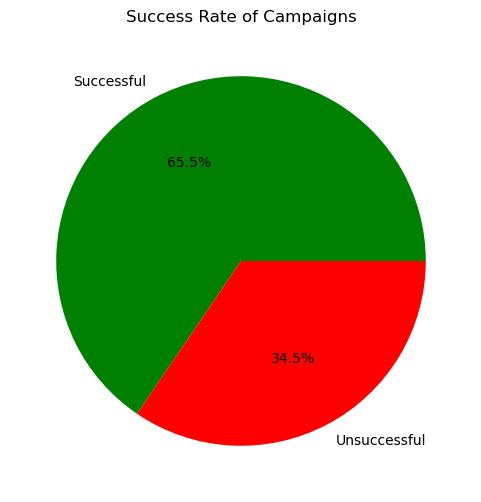

In [10]:
# Pie chart
labels = ["Successful" if idx == 1 else "Unsuccessful" for idx in success_counts.index]
colors = ["green" if idx == 1 else "red" for idx in success_counts.index]

success_counts.plot(kind="pie", labels=labels,
                    autopct='%1.1f%%', colors=colors, figsize=(6, 6))
plt.title("Success Rate of Campaigns")
plt.ylabel("") 
plt.show()

### Top Categories: Most popular campaign categories based on the number of campaigns

In [11]:
category_counts = df1["Category"].value_counts()
category_counts

Category
Shorts           1431
Music            1354
Documentary      1315
Theater           976
Film & Video      950
                 ... 
Letterpress         1
Immersive           1
Installations       1
Webcomics           1
Flight              1
Name: count, Length: 99, dtype: int64

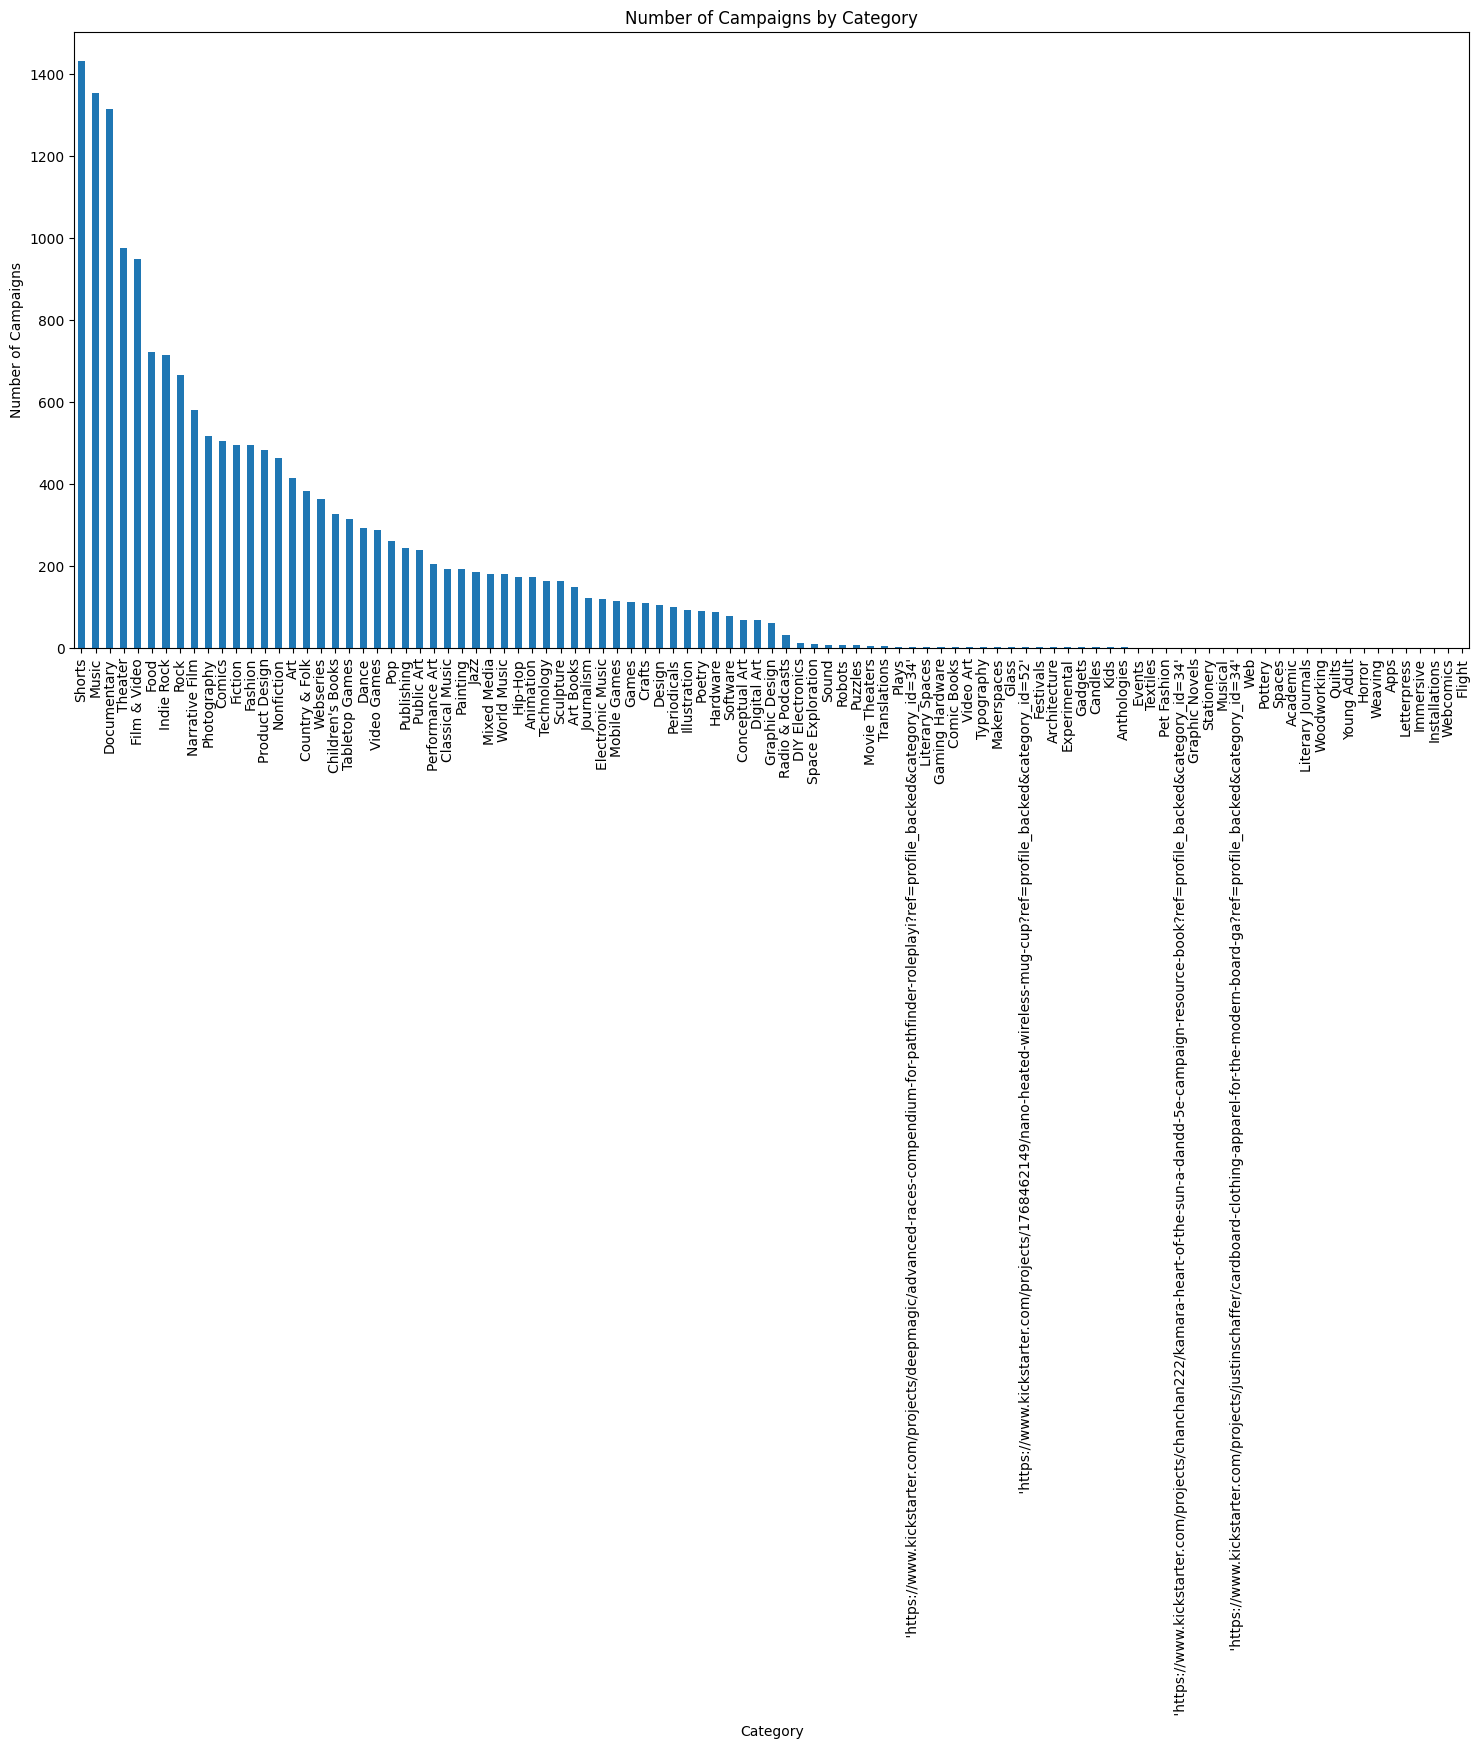

In [78]:
# Bar chart
category_counts.plot(kind="bar", figsize=(18, 8))
plt.title("Number of Campaigns by Category")
plt.xlabel("Category")
plt.ylabel("Number of Campaigns")
plt.xticks(rotation=90) 
plt.show()

### Identify the most active regions for campaigns.

In [79]:
region_counts = combined_df["Location"].value_counts()

region_counts.head(10)


Location
Los Angeles, CA      1594
New York, NY         1425
Brooklyn, NY          635
Chicago, IL           595
San Francisco, CA     572
Portland, OR          398
Seattle, WA           396
Austin, TX            340
Boston, MA            330
Nashville, TN         253
Name: count, dtype: int64

In [80]:
combined_df.to_csv("final_combined.csv")